In [1]:
import os
import nest_asyncio
nest_asyncio.apply()

import pyshark

import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autotime

time: 146 µs (started: 2021-07-31 20:40:17 +02:00)


In [3]:
## Loading data

time: 193 µs (started: 2021-07-31 20:40:17 +02:00)


In [4]:
def loadDataset(path, extraId=""):
    cap = pyshark.FileCapture(path, use_json=True, include_raw=True)
    cap.load_packets()
    raw_data_list = [c.get_raw_packet() for c in cap]

    dataset = []
    
    for raw_data in raw_data_list:
        arr = np.zeros((75, 20, 3), dtype=np.uint8)
        x, y = 0, 0
        for e in raw_data:
            arr[x, y] = [e, e, e]
            x += 1
            if x == 75:
                x = 0
                y += 1
            if y == 20:
                break
        dataset.append(arr)  
    return np.asarray(dataset)

time: 706 µs (started: 2021-07-31 20:40:17 +02:00)


In [5]:
def frameToImg(frame):
    return Image.fromarray(frame, 'RGB')

time: 234 µs (started: 2021-07-31 20:40:17 +02:00)


In [6]:
badQueries = loadDataset('./dataset/badHttpQueriesFiltered.pcap')

badCount = len(badQueries)

time: 1min 28s (started: 2021-07-31 20:40:17 +02:00)


In [7]:
badCount

153824

time: 5.34 ms (started: 2021-07-31 20:41:46 +02:00)


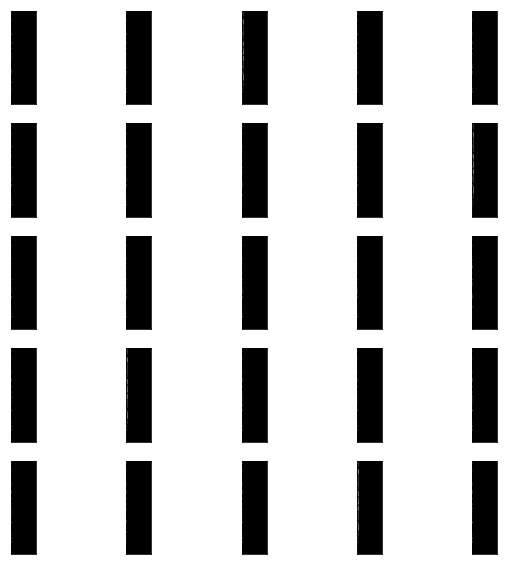

time: 447 ms (started: 2021-07-31 20:41:46 +02:00)


In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(frameToImg(badQueries[i]))
plt.show()

In [9]:
validQueries = loadDataset('./dataset/goodHttpQueriesFiltered.pcap')

validCount = len(validQueries)

time: 1min 33s (started: 2021-07-31 20:41:46 +02:00)


In [10]:
validCount

148962

time: 1.72 ms (started: 2021-07-31 20:43:20 +02:00)


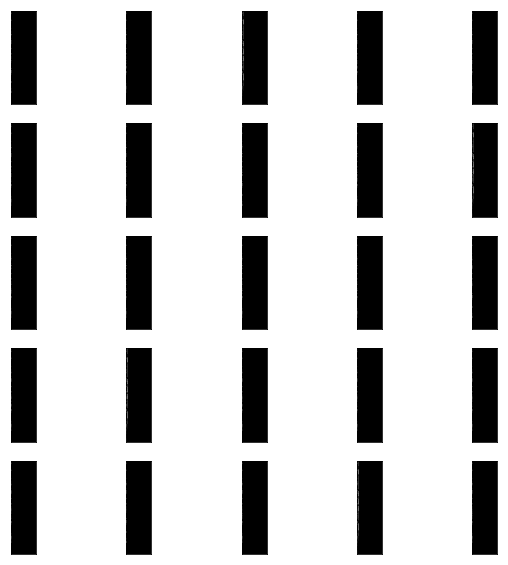

time: 429 ms (started: 2021-07-31 20:43:20 +02:00)


In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(frameToImg(validQueries[i]))
plt.show()

In [12]:
## Preparing the dataset

time: 213 µs (started: 2021-07-31 20:43:20 +02:00)


In [13]:
yBad = [1 for i in range(0, len(badQueries))]  #labels, 1 for malicious and 0 for clean
yGood = [0 for i in range(0, len(validQueries))]

time: 7.84 ms (started: 2021-07-31 20:43:20 +02:00)


In [14]:
X = np.concatenate((badQueries, validQueries), axis=0)
y = yBad + yGood

time: 721 ms (started: 2021-07-31 20:43:20 +02:00)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #splitting data

time: 1.21 s (started: 2021-07-31 20:43:21 +02:00)


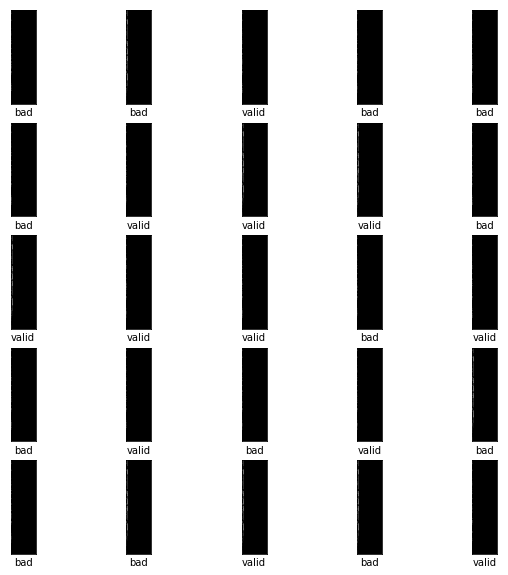

time: 469 ms (started: 2021-07-31 20:43:22 +02:00)


In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(frameToImg(X_test[i]))
    plt.xlabel("bad" if y_test[i] else "valid")
plt.show()

In [17]:
## Building the model

time: 216 µs (started: 2021-07-31 20:43:22 +02:00)


In [18]:
def gen_model(hidden_layer_count, hidden_layer_size, activation_fn='sigmoid'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation=activation_fn, input_shape=(75, 20, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activation_fn))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activation_fn))

    model.add(Flatten())

    for _ in range(hidden_layer_count):
        model.add(Dense(hidden_layer_size, activation=activation_fn))
    model.add(Dense(1, activation='sigmoid'))
    
    #model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

time: 735 µs (started: 2021-07-31 20:43:22 +02:00)


In [19]:
model = gen_model(6, 150, activation_fn='relu')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
time: 183 ms (started: 2021-07-31 20:43:22 +02:00)


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 18, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 9, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 7, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 3, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 1, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               1

In [21]:
model.save("cnn-binary.tmp")

2021-07-31 20:43:23.101754: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-07-31 20:43:23.112829: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2994375000 Hz
2021-07-31 20:43:23.114069: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4987770 executing computations on platform Host. Devices:
2021-07-31 20:43:23.114123: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-07-31 20:43:23.158452: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

time: 262 ms (started: 2021-07-31 20:43:23 +02:00)


In [22]:
## Training

time: 215 µs (started: 2021-07-31 20:43:23 +02:00)


In [23]:
def train_model(model, epochs, batch_size, X_train, y_train, X_test, y_test):
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=3)

    return model, test_loss, test_acc, history

time: 552 µs (started: 2021-07-31 20:43:23 +02:00)


In [24]:
test_acc = 0
while test_acc < 0.7:
    model = tf.keras.models.load_model("cnn-binary.tmp")
    model, test_loss, test_acc, history = train_model(model, 8, 32, X_train, y_train, X_test, y_test)
model.save("cnn-binary.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 242228 samples, validate on 60558 samples
Epoch 1/8
242228/242228 [==============================] - 116s 480us/sample - loss: 0.6933 - acc: 0.5064 - val_loss: 0.6930 - val_acc: 0.5088
Epoch 2/8
242228/242228 [==============================] - 114s 470us/sample - loss: 0.6931 - acc: 0.5077 - val_loss: 0.6931 - val_acc: 0.5088
Epoch 3/8
242228/242228 [==============================] - 116s 478us/sample - loss: 0.6931 - acc: 0.5078 - val_loss: 0.6931 - val_acc: 0.5088
Epoch 4/8
242228/242228 [==============================] - 115s 476us/sample - loss: 0.6931 - acc: 0.5078 - val_loss: 0.6930 - val_acc: 0.5088
Epoch 5/8
242228/242228 [==============================] - 115s 474us/sample - loss: 0.6930 - acc: 0.5078 - val_loss: 0.6930 - val_acc: 0.508

In [25]:
## Metrics

time: 500 µs (started: 2021-07-31 21:47:01 +02:00)


In [26]:
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

Loss:  0.00845736557738949
Accuracy:  0.99707717
time: 1.15 ms (started: 2021-07-31 21:47:01 +02:00)


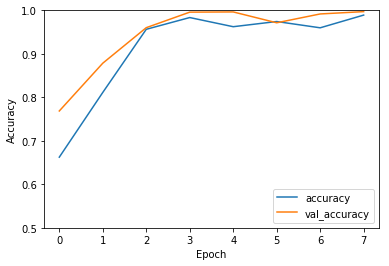

time: 153 ms (started: 2021-08-01 11:00:59 +02:00)


In [33]:
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='accuracy')
elif 'acc' in history.history:
    plt.plot(history.history['acc'], label='accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
elif 'val_acc' in history.history:
    plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [34]:
## Testing

time: 414 µs (started: 2021-08-01 11:01:22 +02:00)


In [35]:
def frame_is_bad(frame):
    return round(max(0., min(1., model.predict(np.asarray([frame]))[0][0])) * 100, 2)

time: 1.73 ms (started: 2021-08-01 11:01:23 +02:00)


In [36]:
print("Is bad ?", frame_is_bad(X_test[0]), "%")

Is bad ? 100.0 %
time: 640 ms (started: 2021-08-01 11:02:18 +02:00)


In [37]:
print("Expected:", y_test[0])

Expected: 1
time: 1.77 ms (started: 2021-08-01 11:02:22 +02:00)
